# Analyse des spécificités des genres

Dans ce carnet est proposée une analyse des spécificités des genres, en relation avec le temps et la langue.



In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [5]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql

In [6]:
from fanalysis.ca import CA 
from fanalysis.mca import MCA

### Importer les données à analyser

In [7]:
### Se connecter à la base de données dans laquelle on va insérer
# le résultat de la requête SPARQL
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [8]:
qr = """
SELECT 
    wp.personne_uri,
    wp.nom_prenom AS nom_prenom,
    wg.genre_code AS genre_code,
    wp2.parti_code AS parti_code,
    wp.annee_naissance AS annee_naissance,
    wp2.parti_uri
FROM 
    wdt_personnes wp
JOIN 
    wdt_personnes_partis wpp ON wp.id = wpp.fk_personne_id
JOIN 
    wdt_partis wp2 ON wp2.id = wpp.fk_parti_id
JOIN 
    wdt_genre wg ON wp.fk_genre_id = wg.id
ORDER BY 
    wp.annee_naissance;
"""

In [9]:
### Vérifier que les données ont été importées correctement
cur = cn.cursor()
l = cur.execute(qr).fetchall()
print(len(l))
l[:3]

940


[('http://www.wikidata.org/entity/Q120229',
  'Robert Tobler',
  'M',
  'FN',
  1901,
  'http://www.wikidata.org/entity/Q672926'),
 ('http://www.wikidata.org/entity/Q120229',
  'Robert Tobler',
  'M',
  'CF',
  1901,
  'http://www.wikidata.org/entity/Q684909'),
 ('http://www.wikidata.org/entity/Q120229',
  'Robert Tobler',
  'M',
  'NeF',
  1901,
  'http://www.wikidata.org/entity/Q13142801')]

In [10]:
### Créer un DataFrame contenant les données
df_parti = pd.DataFrame(l, columns=['uri', 'nom', 'genre',  'parti', 'annee_nais', 'parti_uri'])
df_parti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uri         940 non-null    object
 1   nom         940 non-null    object
 2   genre       940 non-null    object
 3   parti       940 non-null    object
 4   annee_nais  940 non-null    int64 
 5   parti_uri   940 non-null    object
dtypes: int64(1), object(5)
memory usage: 44.2+ KB


In [11]:
### Distribution des genres
df_parti.groupby(by='genre').size().sort_values(ascending=False)

genre
M    730
F    210
dtype: int64

### Codage par périodes de 15 ans

In [12]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_parti['annee_nais'] = df_parti['annee_nais'].astype(int)

In [13]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_parti[df_parti['annee_nais'] < 2020].copy(deep=True)
cdf_p.head(3)

,uri,nom,genre,parti,annee_nais,parti_uri
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,FN,1901,http://www.wikidata.org/entity/Q672926
1,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,CF,1901,http://www.wikidata.org/entity/Q684909
2,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,NeF,1901,http://www.wikidata.org/entity/Q13142801


In [14]:
### Année minimale et maximale dans la population
min(cdf_p['annee_nais']), max(cdf_p['annee_nais'])

(1901, 1994)

In [15]:
### Créer une liste d'années pour séparer en périodes de 15 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_15 = list(range(1901, 1995, 15))
l_15[:5],l_15[-5:]

([1901, 1916, 1931, 1946, 1961], [1931, 1946, 1961, 1976, 1991])

In [16]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['annee_nais'], l_15, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,uri,nom,genre,parti,annee_nais,parti_uri,periodes
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,FN,1901,http://www.wikidata.org/entity/Q672926,1901-1915
1,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,CF,1901,http://www.wikidata.org/entity/Q684909,1901-1915
2,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,NeF,1901,http://www.wikidata.org/entity/Q13142801,1901-1915


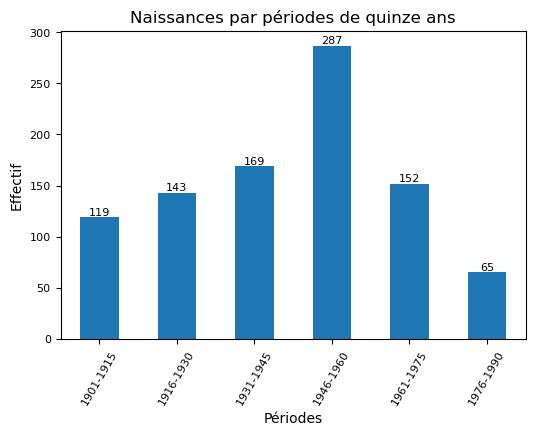

In [17]:
ax = cdf_p.groupby(by='periodes', observed=True).size()\
      .plot(kind='bar',rot=60, fontsize=8, figsize=(6,4))

ax.bar_label(ax.containers[0], fontsize=8)

plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de quinze ans')
plt.show()

### Distributions des genres par périodes

In [18]:
### Tableau de contingence
X = "periodes"  # "0"
Y = "genre"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

C:\Users\LZender\AppData\Local\Temp\ipykernel_19284\1733965624.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)


periodes,1901-1915,1916-1930,1931-1945,1946-1960,1961-1975,1976-1990,Total
genre,,,,,,,
F,2,9,34,83,49,30,207
M,117,134,135,204,103,35,728
Total,119,143,169,287,152,65,935


In [19]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

periodes,1901-1915,1916-1930,1931-1945,1946-1960,1961-1975,1976-1990
genre,,,,,,
F,2,9,34,83,49,30
M,117,134,135,204,103,35


In [20]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 2 , 6 ), effectif: 935 , nombre max. facteurs: 1


In [21]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 88.5164241532369 , dof : 5
p-value : 1.376865582564208e-17
phi2 = inertie (variance totale) : 0.09466997235640309
Cramer:  0.30768485883514496


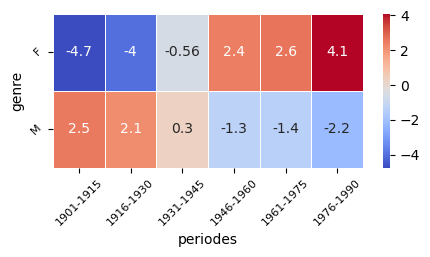

In [22]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(5,2))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=45, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=45, fontsize=8)

plt.show()


#### Commentaire

Comme la variable 'gender' a deux modalités un seul facteur résumé la variance et une analyse factorielle n'est pas utile.

## regroupement des partis par orientation

In [23]:
def orientation_code(o_uri):
    if o_uri == 'http://www.wikidata.org/entity/Q303745':
        # PS
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q385258':
        # UDC
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q13850128':
        # PRD
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q659461':
        # PDC
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q659739':
        # Les Verts
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q202638':
        # PLR
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q667785':
        # PLS
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q550295':
        # alliance des indépendants
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q545900':
        # PVL
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q100934025':
        # le centre
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q151768':
        # parti bourgeois démocrate
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q477228':
        # parti des paysans et artisans indépendants
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667718':
        # parti évangélique suisse
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q661771':
        # parti suisse du travail
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q660046':
        # démocrates suisse ou action nationale
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q668101':
        # ligue des Tessinois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q2145393':
        # mouvement républicain
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q667836':
        # union démocratique fédérale
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q681843':
        # parti démocrate suisse
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q667725':
        # parti chrétien social
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q663580':
        # mouvement citoyens genevois
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q362949':
        # organisation progressistes de Suisse
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q327591':
        # indépendant
        a = 'independant'
    elif o_uri =='http://www.wikidata.org/entity/Q13124':
        # parti libéral démocrate
        a = 'droite_liberale'
    elif o_uri =='http://www.wikidata.org/entity/Q684909':
        # collection fédérale Eidgenössische Sammlung
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q677491':
        # mouvement socio-libéral
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q672946':
        # parti suisse de la liberté
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q672926':
        # front national
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q3366732':
        # parti socialiste autonome
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q3366188':
        # parti chrétien-social indépendant
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q286683':
        # solidaritéS
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q255650':
        # la Gauche alternative linke
        a = 'gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q20012603':
        # ensemble à gauche
        a = 'extreme_gauche'
    elif o_uri =='http://www.wikidata.org/entity/Q13142801':
        # Neue Front
        a = 'extreme_droite'
    elif o_uri =='http://www.wikidata.org/entity/Q1254507':
        # alliance verte et sociale bernoise, grünes bündnis
        a = 'ecologiste'
    elif o_uri =='http://www.wikidata.org/entity/Q1186111':
        # demokratisch-soziale partei
        a = 'centre'
    elif o_uri =='http://www.wikidata.org/entity/Q1084149':
        # parti chrétien-social d'obwald
        a = 'droite_conservatrice'
    elif o_uri =='http://www.wikidata.org/entity/Q10594788':
        # action nationale pour le peuple et la patrie
        a = 'extreme_droite'
    else :
        # orientation autre
        a = 'A'
    return a 

In [24]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
cdf_p['orientation_code'] = cdf_p.apply(lambda x: orientation_code(x['parti_uri']), axis=1)

### Distributions des genres par origines

In [25]:
### Tableau de contingence
X = "genre"
Y = "orientation_code"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre,F,M,Total
orientation_code,,,
centre,53,270,323
droite_conservatrice,3,19,22
droite_liberale,26,75,101
ecologiste,36,29,65
extreme_droite,17,165,182
extreme_gauche,3,6,9
gauche,70,141,211
independant,2,25,27
Total,210,730,940


Si cette table de contingence concerne l'ensemble de la population, on utilise pour la suite la même population que pour l'analyse précédente, limitée donc dans le temps et sans le genre 'A'.

In [26]:
### Tableau de contingence
X = "genre"
Y = "orientation_code"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre,F,M,Total
orientation_code,,,
centre,53,270,323
droite_conservatrice,3,19,22
droite_liberale,26,75,101
ecologiste,36,29,65
extreme_droite,17,165,182
extreme_gauche,3,6,9
gauche,70,141,211
independant,2,25,27
Total,210,730,940


In [27]:
### Production du tableau à analyser
D = ddf.iloc[:-1,:-1].copy(deep=True)
D

genre,F,M
orientation_code,,
centre,53,270
droite_conservatrice,3,19
droite_liberale,26,75
ecologiste,36,29
extreme_droite,17,165
extreme_gauche,3,6
gauche,70,141
independant,2,25


In [28]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 8 , 2 ), effectif: 940 , nombre max. facteurs: 1


In [29]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 85.19639853775611 , dof : 7
p-value : 1.1949884544040314e-15
phi2 = inertie (variance totale) : 0.09063446652952778
Cramer:  0.3010555871089719


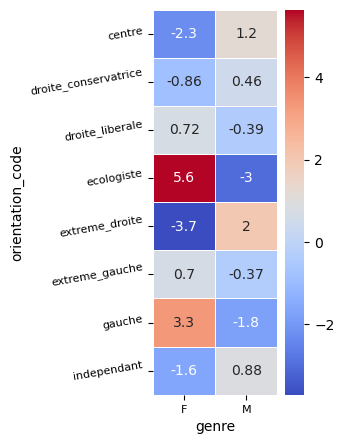

In [30]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(2,5))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=0, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=10, fontsize=8)



plt.show()


## Analyser le lien entre genre+période et le parti politique

Cette analyse plus fine permet de comparer trois variable mais dans une logique bivariée

In [31]:
cdf_p.periodes = cdf_p.periodes.astype("str")
cdf_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uri               940 non-null    object
 1   nom               940 non-null    object
 2   genre             940 non-null    object
 3   parti             940 non-null    object
 4   annee_nais        940 non-null    int32 
 5   parti_uri         940 non-null    object
 6   periodes          940 non-null    object
 7   orientation_code  940 non-null    object
dtypes: int32(1), object(7)
memory usage: 55.2+ KB


In [32]:
cdf_p['genre_periodes'] = cdf_p.apply(lambda x: \
                    x.periodes + '_' + x.genre, axis=1)
cdf_p.head()

,uri,nom,genre,parti,annee_nais,parti_uri,periodes,orientation_code,genre_periodes
0,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,FN,1901,http://www.wikidata.org/entity/Q672926,1901-1915,extreme_droite,1901-1915_M
1,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,CF,1901,http://www.wikidata.org/entity/Q684909,1901-1915,extreme_droite,1901-1915_M
2,http://www.wikidata.org/entity/Q120229,Robert Tobler,M,NeF,1901,http://www.wikidata.org/entity/Q13142801,1901-1915,extreme_droite,1901-1915_M
3,http://www.wikidata.org/entity/Q1579473,Hans Fischer,M,PRD,1901,http://www.wikidata.org/entity/Q659461,1901-1915,centre,1901-1915_M
4,http://www.wikidata.org/entity/Q1447990,Franz Landolt,M,PS,1901,http://www.wikidata.org/entity/Q303745,1901-1915,gauche,1901-1915_M


In [33]:
cdf_p.groupby(by='genre_periodes').size()


genre_periodes
1901-1915_F      2
1901-1915_M    117
1916-1930_F      9
1916-1930_M    134
1931-1945_F     34
1931-1945_M    135
1946-1960_F     83
1946-1960_M    204
1961-1975_F     49
1961-1975_M    103
1976-1990_F     30
1976-1990_M     35
nan_F            3
nan_M            2
dtype: int64

In [34]:
### Tableau de contingence
X = "genre_periodes"
Y = "orientation_code"

ddf = cdf_p[[Y,X]].pivot_table(index=Y,columns=X,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

genre_periodes,1901-1915_F,1901-1915_M,1916-1930_F,1916-1930_M,1931-1945_F,1931-1945_M,1946-1960_F,1946-1960_M,1961-1975_F,1961-1975_M,1976-1990_F,1976-1990_M,nan_F,nan_M,Total
orientation_code,,,,,,,,,,,,,,,
centre,2,47,4,67,15,65,23,59,9,25,0,7,0,0,323
droite_conservatrice,0,1,0,3,0,4,2,9,0,2,1,0,0,0,22
droite_liberale,0,7,1,5,1,6,9,25,10,25,5,6,0,1,101
ecologiste,0,0,0,1,4,3,15,15,10,5,5,5,2,0,65
extreme_droite,0,20,0,23,1,27,3,54,5,31,8,9,0,1,182
extreme_gauche,0,1,1,2,0,0,1,3,1,0,0,0,0,0,9
gauche,0,29,3,27,11,24,30,38,14,15,11,8,1,0,211
independant,0,12,0,6,2,6,0,1,0,0,0,0,0,0,27
Total,2,117,9,134,34,135,83,204,49,103,30,35,3,2,940


In [35]:
### Liste construite manuellement à partir de cette liste
# print(ddf.index.to_list())

li = ['centre', 'droite_conservatrice', 'droite_liberale', 'ecologiste', 'extreme_droite', 'extreme_gauche', 'gauche', 'independant']

In [36]:
lc = ddf.columns.to_list()[:-1]

In [37]:
D = ddf.loc[li,lc].copy(deep=True)
D

genre_periodes,1901-1915_F,1901-1915_M,1916-1930_F,1916-1930_M,1931-1945_F,1931-1945_M,1946-1960_F,1946-1960_M,1961-1975_F,1961-1975_M,1976-1990_F,1976-1990_M,nan_F,nan_M
orientation_code,,,,,,,,,,,,,,
centre,2,47,4,67,15,65,23,59,9,25,0,7,0,0
droite_conservatrice,0,1,0,3,0,4,2,9,0,2,1,0,0,0
droite_liberale,0,7,1,5,1,6,9,25,10,25,5,6,0,1
ecologiste,0,0,0,1,4,3,15,15,10,5,5,5,2,0
extreme_droite,0,20,0,23,1,27,3,54,5,31,8,9,0,1
extreme_gauche,0,1,1,2,0,0,1,3,1,0,0,0,0,0
gauche,0,29,3,27,11,24,30,38,14,15,11,8,1,0
independant,0,12,0,6,2,6,0,1,0,0,0,0,0,0


In [38]:
## Nombre de modalités ligne
K = D.shape[0]
## Nombre de modalités colonnes
L = D.shape[1]
# Effectif total
n = np.sum(D.values)
# Nombre max. de facteur
Hmax = np.min([K-1,L-1])

print('Dimensions: (', K, ',', L, '), effectif:', n, ', nombre max. facteurs:', Hmax)

Dimensions: ( 8 , 14 ), effectif: 940 , nombre max. facteurs: 7


In [39]:
### Valeurs produites par la fonction de la librairie 'stats'
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),4)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 277.9035095675789 , dof : 91
p-value : 8.453307576373112e-21
phi2 = inertie (variance totale) : 0.29564203145487117
Cramer:  0.20551052508843543


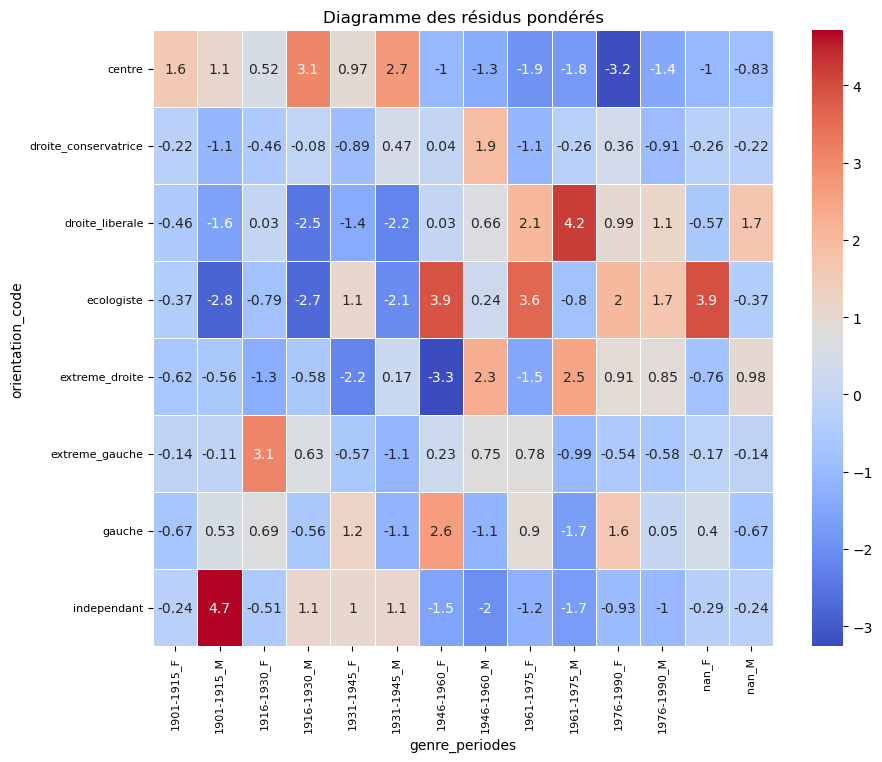

In [40]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index


fig, ax = plt.subplots(figsize=(10,8))         
# Sample figsize in inches
g = sns.heatmap(residus_ponderes, annot=residus_ponderes, 
                cmap="coolwarm", linewidths=.5, ax=ax)
labelsx = residus_ponderes.columns
labelsy = residus_ponderes.index
xt = g.set_xticklabels(labelsx, rotation=90, fontsize=8)
yt = g.set_yticklabels(labelsy, rotation=0, fontsize=8)


g.set_title('Diagramme des résidus pondérés')

plt.savefig('images/genre_periode_parti_resid_ponderes.jpg', bbox_inches='tight')
plt.show()


In [41]:
afc = CA(row_labels=D.index,col_labels=D.columns)
afc.fit(D.values)

CA(col_labels=Index(['1901-1915_F', '1901-1915_M', '1916-1930_F', '1916-1930_M',
       '1931-1945_F', '1931-1945_M', '1946-1960_F', '1946-1960_M',
       '1961-1975_F', '1961-1975_M', '1976-1990_F', '1976-1990_M', 'nan_F',
       'nan_M'],
      dtype='object', name='genre_periodes'),
   row_labels=Index(['centre', 'droite_conservatrice', 'droite_liberale', 'ecologiste',
       'extreme_droite', 'extreme_gauche', 'gauche', 'independant'],
      dtype='object', name='orientation_code'))

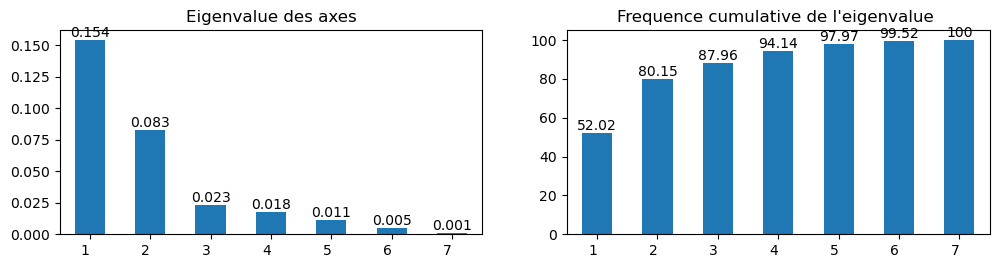

In [42]:
eig = pd.DataFrame(afc.eig_)

r1 = round(eig.iloc[0], 3)
r2 = round(eig.iloc[2], 2)
s=list(range(1,len(r1)+1))
r1.index=s
r2.index=s

# https://www.statology.org/pandas-subplots/
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

ax1 = r1.plot(kind='bar', ax=axes[0], title='Eigenvalue des axes')
ax2 = r2.plot(kind='bar', ax=axes[1], title="Frequence cumulative de l'eigenvalue ")


ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])


# Met les valeurs xticks en vertical
fig.autofmt_xdate(rotation=0)
plt.show()

### Graphiques et interprétation du premier plan factoriel

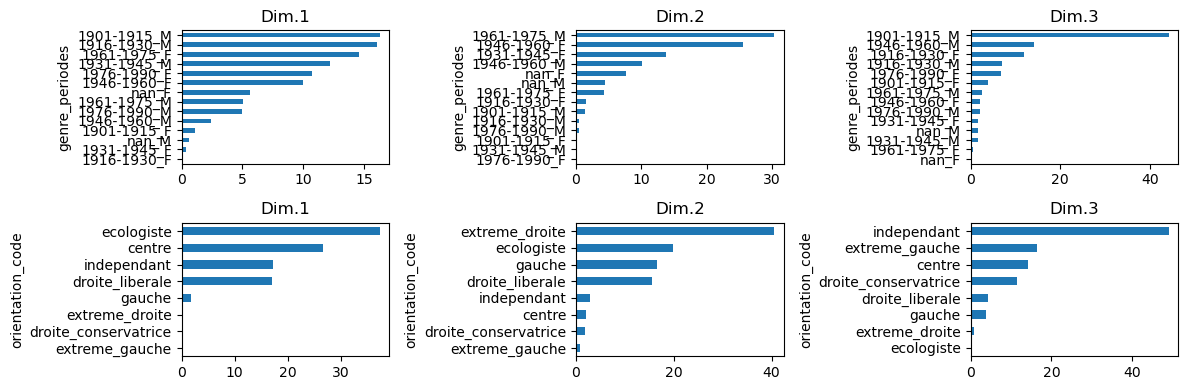

In [43]:
# Informations sur les contributions des colonnes
df = afc.col_topandas()[['col_contrib_dim1',
                         'col_contrib_dim2',
                         'col_contrib_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,4))

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Rows
df = afc.row_topandas()[['row_contrib_dim1',
                         'row_contrib_dim2',
                         'row_contrib_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

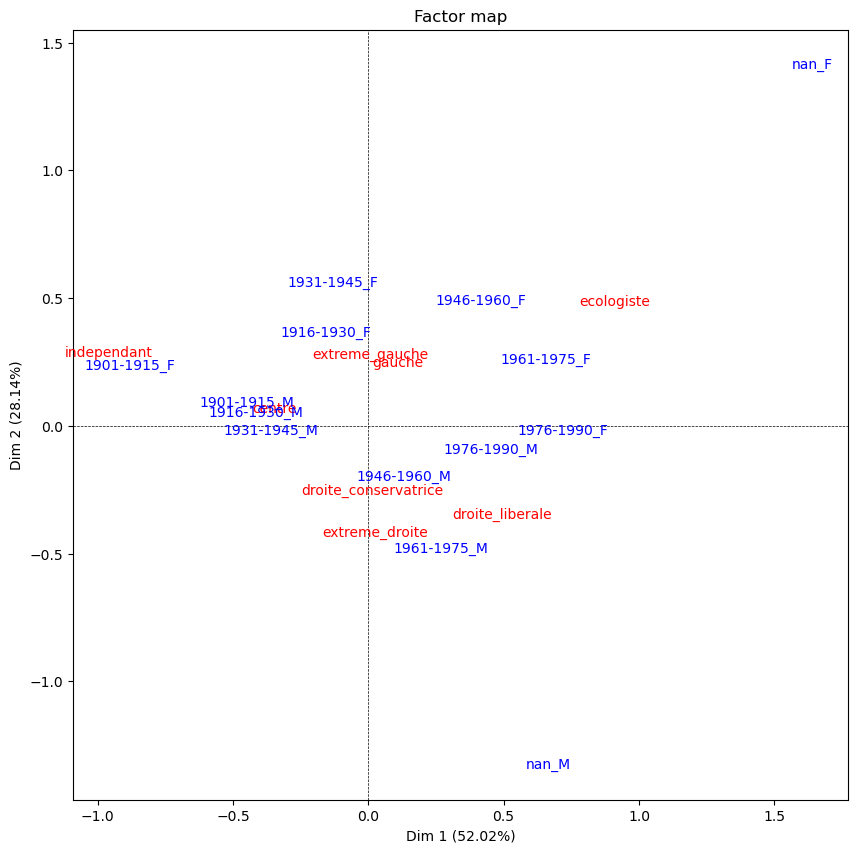

In [44]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=1,num_y_axis=2,figsize=(10,10))


### Représenter l'autre plan factoriel

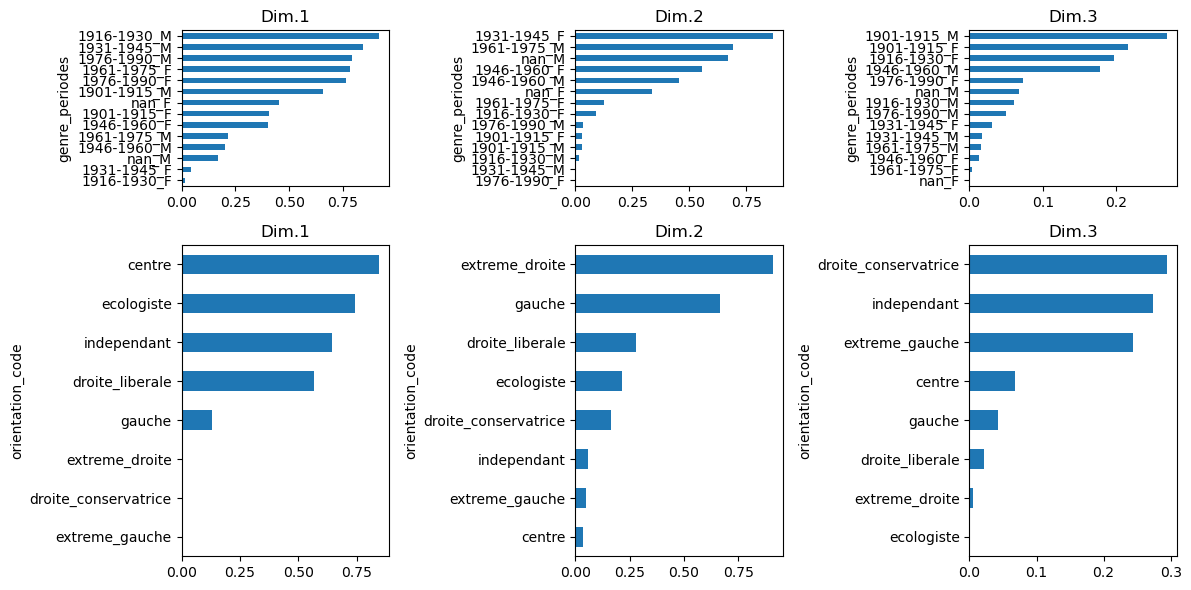

In [45]:
### Informations sur les cosinus carrés. Ces valeurs expriment 
# la qualité de représentation d'une modalité sur l'axe correspondant

### Colonnes
df = afc.col_topandas()[['col_cos2_dim1',
                         'col_cos2_dim2',
                         'col_cos2_dim3']]

r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), 
                         gridspec_kw={'height_ratios': [1, 2]})

r1.sort_values().plot(kind='barh', ax=axes[0,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[0,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[0,2], title='Dim.3')

### Lignes
df = afc.row_topandas()[['row_cos2_dim1',
                         'row_cos2_dim2',
                         'row_cos2_dim3']]
r1 = df.iloc[:,0]
r2 = df.iloc[:,1]
r3 = df.iloc[:,2]

r1.sort_values().plot(kind='barh', ax=axes[1,0], title='Dim.1')
r2.sort_values().plot(kind='barh', ax=axes[1,1], title='Dim.2')
r3.sort_values().plot(kind='barh', ax=axes[1,2], title='Dim.3')

plt.tight_layout()
plt.show()

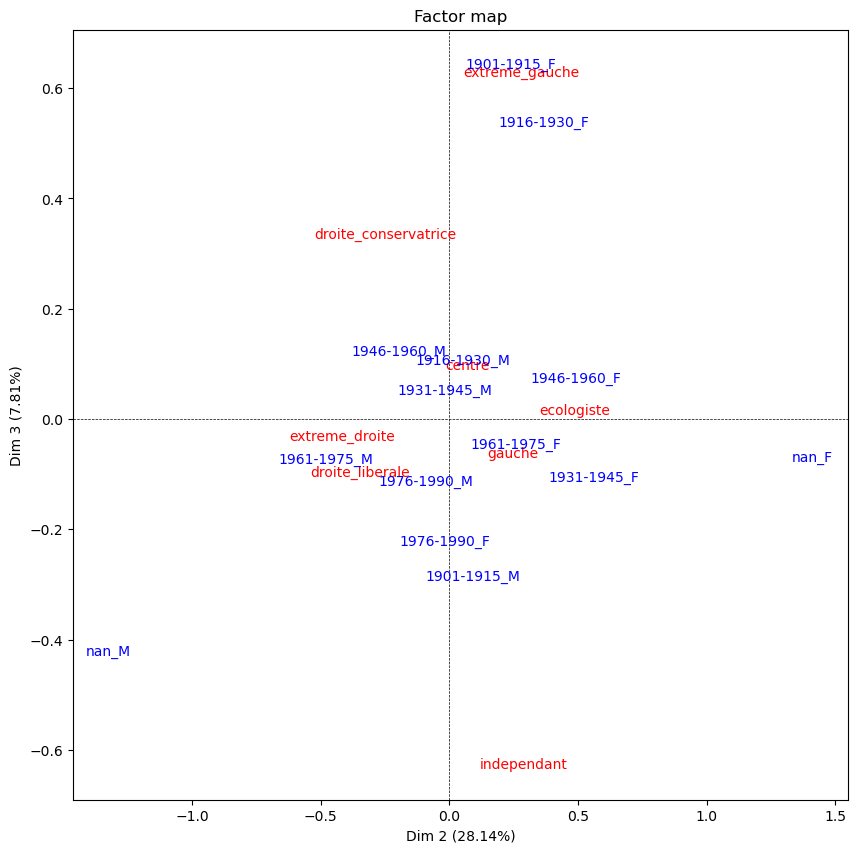

In [46]:
# Représentation simultanée, avec amplification
afc.mapping(num_x_axis=2,num_y_axis=3,figsize=(10,10))

### Commentaire

Cette analyse factorielle met en évidence, en relation avec le diagramme des résidus pondérés qui permet de la contrôler, les moments de présence féminine significative dans les générations présentes dans les  différentes orientations politiques